In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
from source.utils import *
from source.classes import *
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

In [3]:
with open('../../Desktop/DLC_social_1/DLC_social_1_exp_conditions.pickle', 'rb') as handle:
    Treatment_dict = pickle.load(handle)

In [4]:
#Which angles to compute?
bp_dict = {'B_Nose':['B_Left_ear','B_Right_ear'],
          'B_Left_ear':['B_Nose','B_Right_ear','B_Center','B_Left_flank'],
          'B_Right_ear':['B_Nose','B_Left_ear','B_Center','B_Right_flank'],
          'B_Center':['B_Left_ear','B_Right_ear','B_Left_flank','B_Right_flank','B_Tail_base'],
          'B_Left_flank':['B_Left_ear','B_Center','B_Tail_base'],
          'B_Right_flank':['B_Right_ear','B_Center','B_Tail_base'],
          'B_Tail_base':['B_Center','B_Left_flank','B_Right_flank']}

In [15]:
DLC_social_1 = get_coordinates(path='../../Desktop/DLC_social_1/',#Path where to find the required files
                               p=16,                              #Number of processes used for parallelization
                               smooth_alpha=0,                    #Alpha value for exponentially weighted smoothing
                               distances=False,#['B_Center','B_Nose','B_Left_ear','B_Right_ear','B_Left_flank',
                                          #'B_Right_flank','B_Tail_base'],
                               ego=False,
                               angles=True,
                               connectivity=bp_dict,
                               arena='circular',                  #Type of arena used in the experiments
                               arena_dims=[380],                  #Dimensions of the arena. Just one if it's circular
                               video_format='.mp4',
                               table_format='.h5',
                               exp_conditions=Treatment_dict)

In [43]:
%%time
DLC_social_1_coords = DLC_social_1.run(verbose=True)

Loading and smoothing trajectories...
Done!
CPU times: user 2.3 s, sys: 565 ms, total: 2.87 s
Wall time: 3.21 s


In [47]:
%%time
test = DLC_social_1_coords.get_coords(center=True, polar=False)
test._type

CPU times: user 13.9 s, sys: 82.5 ms, total: 14 s
Wall time: 14 s


'coords'

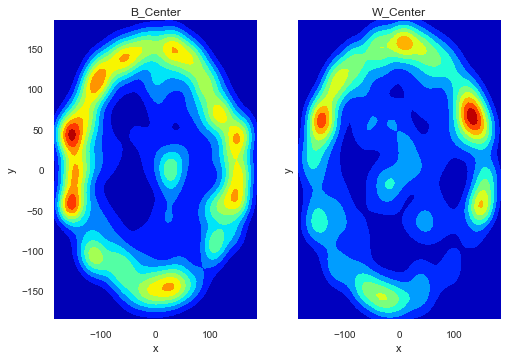

In [21]:
test.plot_heatmaps(['B_Center', 'W_Center'], i=2)

In [22]:
%%time
test = DLC_social_1_coords.get_distances()

ValueError: Distances not computed. Read the documentation for more details

In [46]:
%%time
test = DLC_social_1_coords.get_angles(degrees=True)
test._type

CPU times: user 40.5 ms, sys: 21.3 ms, total: 61.8 ms
Wall time: 61.2 ms


'angles'

# Angle computing draft 

In [ ]:
import numpy as np
from numpy.core.umath_tests import inner1d

def angle(a,b,c, degrees=False):

    ba = a - b
    bc = c - b

    cosine_angle = inner1d(ba, bc) / (np.linalg.norm(ba, axis=1) * np.linalg.norm(bc, axis=1))
    angle = np.arccos(cosine_angle)
    
    if degrees:
        return np.degrees(angle)
    
    return angle

In [ ]:
def angle_trio(array, degrees=False):
    
    a, b, c = array
    
    return np.array([angle(a, b, c, degrees=degrees),
                     angle(a, c, b, degrees=degrees),
                     angle(b, a, c, degrees=degrees)])

In [ ]:
def table_dict_angles(connectivity, table_dict, degrees=False):
    '''
    
    Computes all the angles between adjacent bodypart trios per video and per frame in the data.
    Parameters:
        connectivity (dictionary): dict stating to which bodyparts each bodypart is connected;
        table_dict (dict of dataframes): tables loaded from the data;
        degrees (bool): Flag stating if the result should be in degrees. Radians if False.
        draw (bool): Draws a simple connectivity graph if True. False by default.
        
    Output:
        angle_dict (dictionary): dict containing angle dataframes per video
    
    '''
    
    bp_net = nx.Graph(connectivity)
    cliques = nx.enumerate_all_cliques(bp_net)
    cliques = [i for i in cliques if len(i) == 3]
    
    angle_dict = {}
    for key,tab in table_dict.items():
    
        dats = []
        for clique in cliques:
            dat = pd.DataFrame(angle_trio(np.array(tab[clique]).reshape(3,tab.shape[0],2), degrees=degrees)).T
            
            orders = [[0,1,2],[0,2,1],[1,0,2]]
            dat.columns = [tuple(clique[i] for i in order) for order in orders]
            
            dats.append(dat)
            
        dats = pd.concat(dats, axis=1)
        
        angle_dict[key] = dats
        
    return angle_dict

In [ ]:
example = DLC_social_1_coords.get_coords(center=False, polar=False)

In [ ]:
%%time
table_dict_angles(bp_dict, example, degrees=True)

In [ ]:
ba = a - b
bc = c - b

print(ba)
print(bc)

dots = []
for a in range(len(ba)):
    dots.append(np.dot(ba[a], bc[a]))
    
print(dots)

from numpy.core.umath_tests import inner1d

cosine_angle = inner1d(ba, bc)
print(np.linalg.norm(ba, axis=1))

print(cosine_angle)

In [ ]:
%%time
angle_trio(np.array([a[0], b[0], c[0]]), degrees=True)

In [ ]:
%%time
angle_trio([a, b, c], degrees=False).shape

In [ ]:
np.array([a, b, c]).shape

In [ ]:
example

In [ ]:
example[all_cliques[0]]

In [ ]:
%%time
dats = []
for clique in all_cliques:
    dats.append(pd.DataFrame(angle_trio(np.array(example[clique]).reshape(3,14999,2), degrees=True)))
dats = pd.concat(dats).T

In [ ]:
dats

In [ ]:
plt.plot(dats.iloc[:,0])

In [ ]:
example